In [1]:
# run_hp.py

import sys
import argparse
import os
from pathlib import Path
from dask import delayed, compute
import sys
import glob
sys.path.append("/ccsopen/home/braut/projects/xprecipradarhp_vap_proc/sail_hp_src")  # or full path: "/home/yourname/projects/xprecipradarhp_vap_proc/test_hp"

from hp_processing import process_file
from write_outnc import write_ds_to_nc

from config import CONFIG



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
CONFIG

{'input_file_pattern': 'gucxprecipradarcmacppiS2.c1',
 'output_file_pattern': 'gucxprecipradarcmacppihpS2.c1',
 'fill_value': -9999,
 'filter_fields': ['corrected_reflectivity',
  'corrected_differential_reflectivity',
  'corrected_specific_diff_phase',
  'RHOHV',
  'sounding_temperature',
  'hp_semisupervised',
  'hp_fhc_summer',
  'hp_fhc_winter'],
 'additional_fields': ['corrected_reflectivity'],
 'x_grid_limits': (-20000.0, 20000.0),
 'y_grid_limits': (-20000.0, 20000.0),
 'z_grid_limits': (500.0, 5000.0),
 'grid_resolution': 250,
 'classification_fields': {'summer': {'field_name': 'hp_fhc_summer',
   'long_name': 'HydroPhase from CSU Summer',
   'function': 'classify_summer'},
  'winter': {'field_name': 'hp_fhc_winter',
   'long_name': 'HydroPhase from CSU Winter',
   'function': 'classify_winter'},
  'pyart': {'field_name': 'hp_semisupervised',
   'long_name': 'HydroPhase from Py-ART',
   'function': 'classify_pyart'}},
 'variable_mapping': {'corrected_reflectivity': 'corrected_r

In [3]:


def unprocessed_files(files, output_dir, config):
    out = []
    for file in files:
        base = os.path.basename(file)
        outfile = base.replace(config["input_file_pattern"], config["output_file_pattern"])
        if not os.path.exists(os.path.join(output_dir, outfile)):
            out.append(file)
    return out


In [4]:

# Manual config for notebook
year = "2022"
month = "08"
season = "summer"
rerun = False

data_dir = Path("/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/")
output_dir = Path("/ccsopen/home/braut/projects/xprecipradarhp_vap_proc/test_output") / f"{year}{month}"
dod_template = "/ccsopen/home/braut/projects/xprecipradarhp_vap_proc/sail_hp_src/dod_v1-3.txt"

output_dir.mkdir(parents=True, exist_ok=True)

# Collect files
files = sorted((data_dir / f"{year}{month}").glob("gucxprecipradarcmacppiS2.c1.*.nc"))

# Filter files
files_to_process = files if rerun else unprocessed_files(files, output_dir, CONFIG)
print(f"{len(files_to_process)} files selected for processing.")

# Process first file
test_file = Path("/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/202208/gucxprecipradarcmacppiS2.c1.20220825.192243.nc")
#test_file = files_to_process[-1480]
ds = process_file(test_file, CONFIG, season)

filename = test_file.name
outname = filename.replace(CONFIG['input_file_pattern'], CONFIG['output_file_pattern'])
output_path = output_dir / outname


7411 files selected for processing.


/autofs/nccsopen-svm1_home/braut/data-env1/lib/python3.12/site-packages/pyart/io/cfradial.py:424: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/autofs/nccsopen-svm1_home/braut/data-env1/lib/python3.12/site-packages/pyart/io/cfradial.py:424: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/autofs/nccsopen-svm1_home/braut/data-env1/lib/python3.12/site-packages/pyart/retrieve/echo_class.py:679: UserWarning: Using radar frequency from instrument parameters: 9200000000.0
  warn(f"Using radar frequency from instrument parameters: {frequency}")
/autofs/nccsopen-svm1_home/braut/data-env1/lib/python3.12/site-packages/pyart/retrieve/echo_class.py:679: UserWarning: Using radar frequency from instrument parameters: 9200000000.0
  warn(f"Using radar frequency from instrument parameters: {frequency}")


In [5]:
dod_template = "/ccsopen/home/braut/projects/xprecipradarhp_vap_proc/sail_hp_src/dod_v1-3.txt"
write_ds_to_nc(ds, dod_template, output_path, CONFIG)


In [6]:
output_path


PosixPath('/ccsopen/home/braut/projects/xprecipradarhp_vap_proc/test_output/202208/gucxprecipradarcmacppihpS2.c1.20220825.192243.nc')

## Visualize Output

Read the output NetCDF file and create visualization plots

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import numpy as np
import xarray as xr

In [8]:
# Read output NetCDF file
output_ds = xr.open_dataset(output_path)
output_ds

<xarray.Dataset>
Dimensions:                 (time: 1, y: 160, x: 160)
Coordinates:
  * time                    (time) datetime64[ns] 2022-08-25T19:22:43
  * y                       (y) float64 -2e+04 -1.975e+04 ... 1.975e+04 2e+04
  * x                       (x) float64 -2e+04 -1.975e+04 ... 1.975e+04 2e+04
    lat                     (y, x) float64 ...
    lon                     (y, x) float64 ...
Data variables:
    base_time               datetime64[ns] ...
    time_offset             (time) datetime64[ns] ...
    corrected_reflectivity  (time, y, x) float64 ...
    hp_fhc                  (time, y, x) float32 ...
    hp_ssc                  (time, y, x) float32 ...
    lowest_height           (time, y, x) float64 ...
    radar_lat               float64 ...
    radar_lon               float64 ...
    radar_alt               float64 ...
Attributes: (12/23)
    command_line:          /autofs/nccsopen-svm1_home/braut/data-env1/lib/pyt...
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       HP-v1.0
    dod_version:           xprecipradarhp-c1-1.3
    input_datastreams:     gucxprecipradarcmacppiS2.c1
    site_id:               guc
    ...                    ...
    developers:            Bhupendra Raut, ANL., Joseph O'Brien, ANL., Maxwel...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    fields:                base_time, time_offset, time, corrected_reflectivi...
    history:               created on 2025-11-19 00:12:16 UTC on cirrus-login...

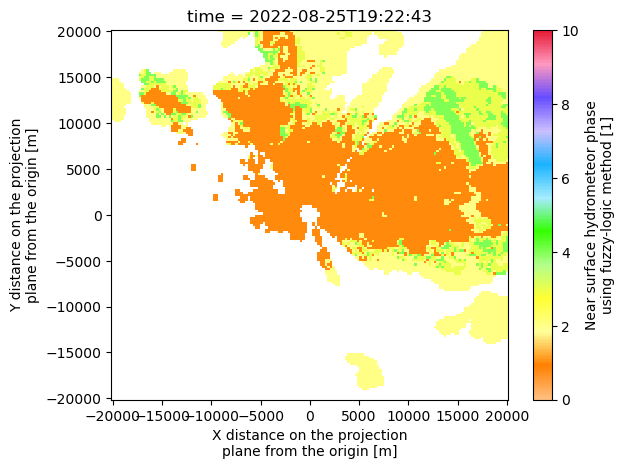

In [9]:
output_ds.hp_fhc.plot(cmap='pyart_Cat12', vmin=0, vmax=10)

In [10]:
# Define color mapping for classification
colors = {
    'Unclassified': '#008837',  # Dark Green
    'Liquid': '#a6dba0',          # Light Green
    'LD_Frozen': '#c2a5cf',          # Light Purple
    'HD_Frozen': '#7b3294',  # Dark Purple
    'Melting': '#FFC107',  # Yellow
}

# Create colormap for classification (5 categories)
cmap_classification = ListedColormap([
    colors['Unclassified'],
    colors['Liquid'],
    colors['LD_Frozen'],
    colors['HD_Frozen'],
    colors['Melting']
])

# Get PyART ChaseSpectral colormap for reflectivity
import pyart


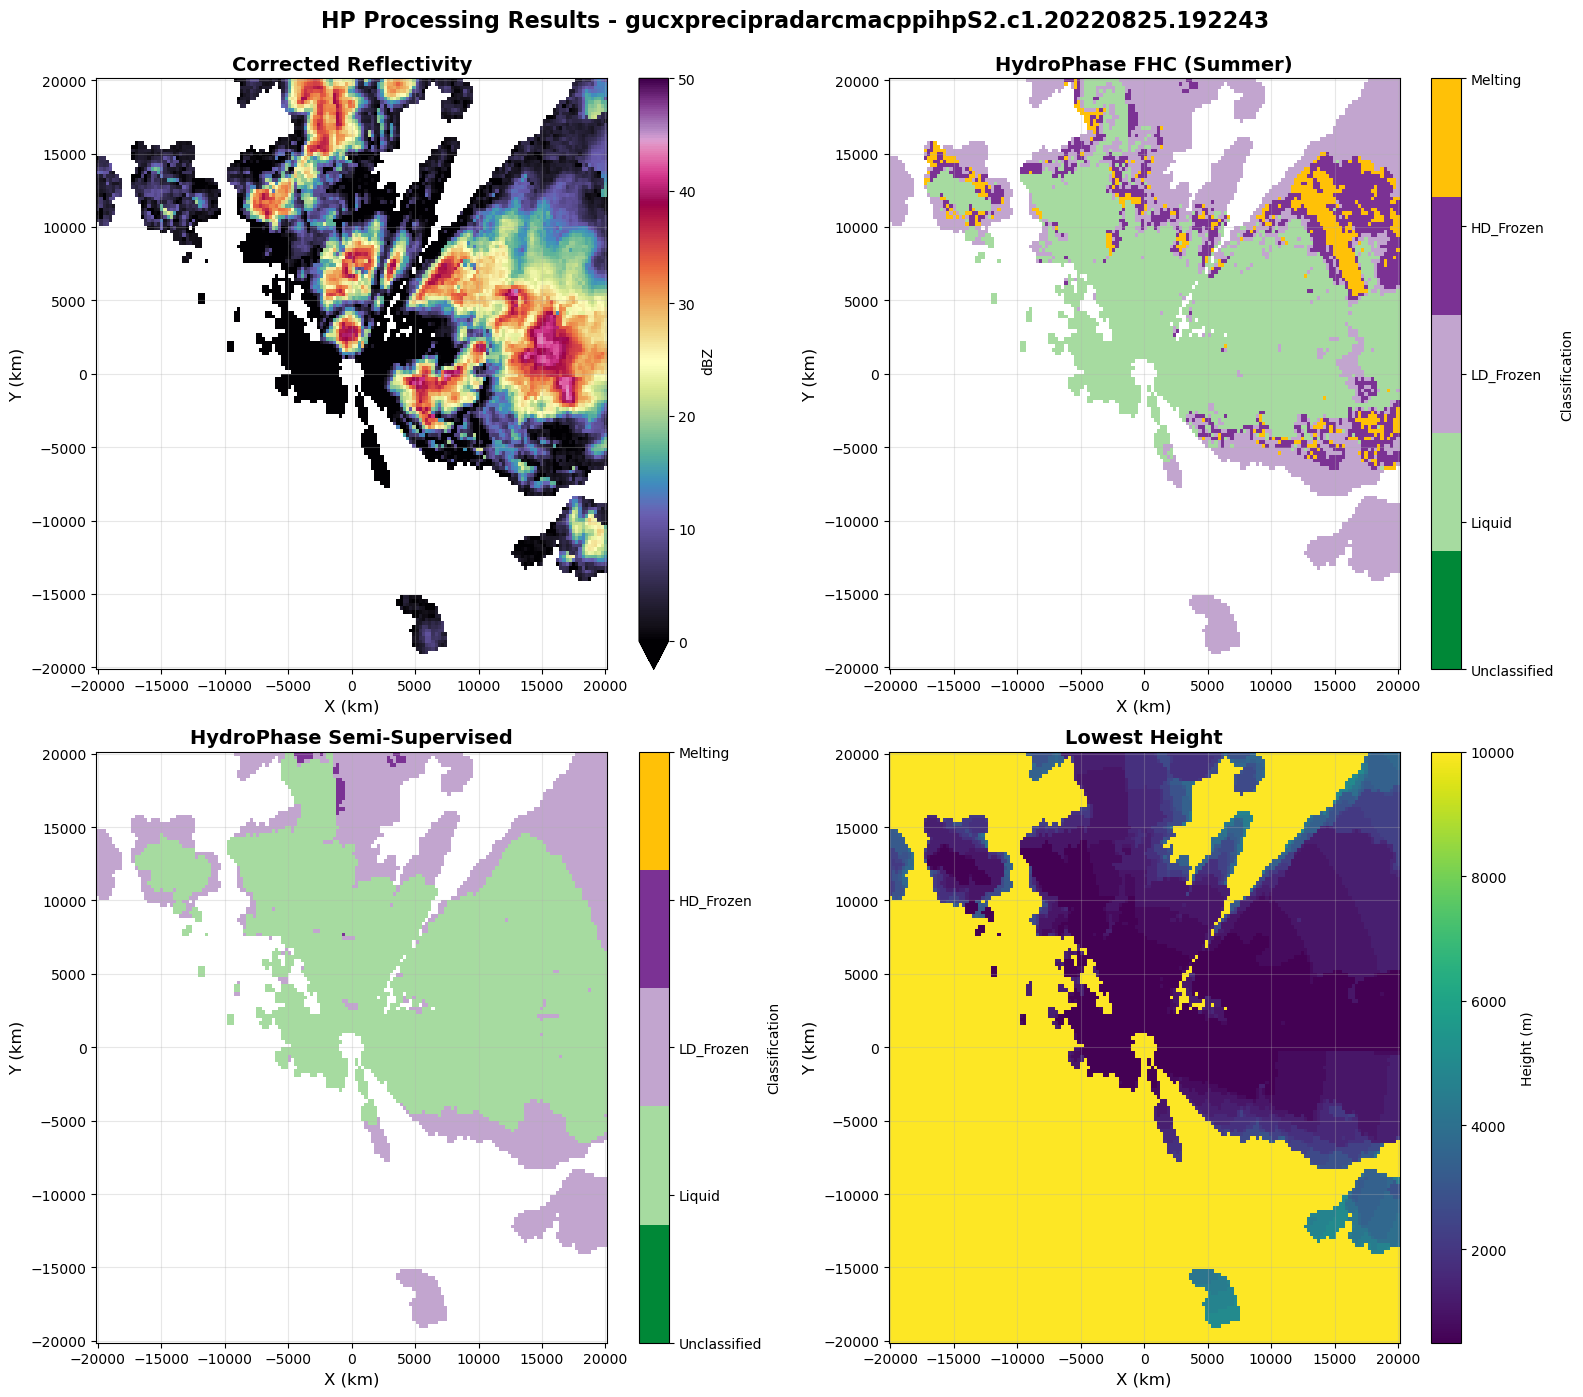

In [11]:
# Create 2x2 panel plot using simple xarray plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Corrected Reflectivity
ax = axes[0, 0]
output_ds['corrected_reflectivity'].plot(
    ax=ax,
    cmap='pyart_ChaseSpectral',
    vmin=0,
    vmax=50,
    cbar_kwargs={'label': 'dBZ'}
)
ax.set_title('Corrected Reflectivity', fontsize=14, fontweight='bold')
ax.set_xlabel('X (km)', fontsize=12)
ax.set_ylabel('Y (km)', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 2: HP FHC Classification
ax = axes[0, 1]
output_ds['hp_fhc'].plot(
    ax=ax,
    cmap=cmap_classification,
    vmin=0,
    vmax=4,
    cbar_kwargs={
        'label': 'Classification',
        'ticks': [0, 1, 2, 3, 4]
    }
)
# Update colorbar labels
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Unclassified', 'Liquid', 'LD_Frozen', 'HD_Frozen', 'Melting'])
ax.set_title(f'HydroPhase FHC ({season.title()})', fontsize=14, fontweight='bold')
ax.set_xlabel('X (km)', fontsize=12)
ax.set_ylabel('Y (km)', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 3: HP Semi-Supervised Classification
ax = axes[1, 0]
output_ds['hp_ssc'].plot(
    ax=ax,
    cmap=cmap_classification,
    vmin=0,
    vmax=4,
    cbar_kwargs={
        'label': 'Classification',
        'ticks': [0, 1, 2, 3, 4]
    }
)
# Update colorbar labels
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Unclassified', 'Liquid', 'LD_Frozen', 'HD_Frozen', 'Melting'])
ax.set_title('HydroPhase Semi-Supervised', fontsize=14, fontweight='bold')
ax.set_xlabel('X (km)', fontsize=12)
ax.set_ylabel('Y (km)', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 4: Lowest Height
ax = axes[1, 1]
output_ds['lowest_height'].plot(
    ax=ax,
    cmap='viridis',
    cbar_kwargs={'label': 'Height (m)'}
)
ax.set_title('Lowest Height', fontsize=14, fontweight='bold')
ax.set_xlabel('X (km)', fontsize=12)
ax.set_ylabel('Y (km)', fontsize=12)
ax.grid(True, alpha=0.3)

# Add overall title
fig.suptitle(f"HP Processing Results - {output_path.stem}", 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

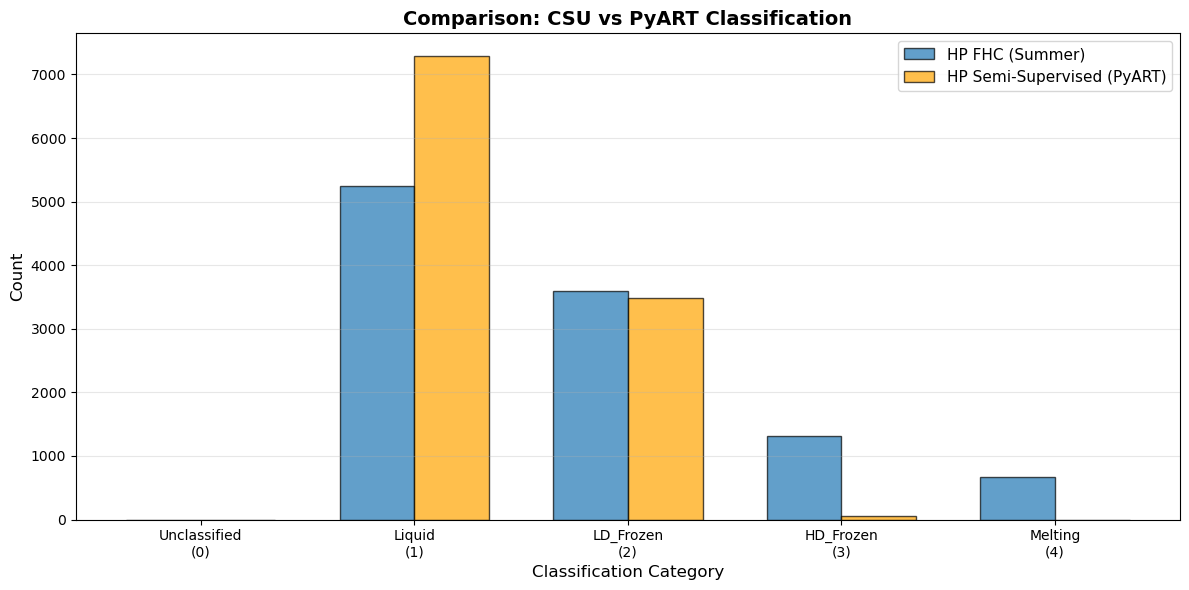

In [14]:
# Create side-by-side (dodged) histogram comparing CSU and PyART classifications
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate histograms for both classifications
hp_fhc_vals = output_ds.hp_fhc.values.flatten()
hp_ssc_vals = output_ds.hp_ssc.values.flatten()

# Remove NaN values
hp_fhc_vals = hp_fhc_vals[~np.isnan(hp_fhc_vals)]
hp_ssc_vals = hp_ssc_vals[~np.isnan(hp_ssc_vals)]

# Count occurrences for each category (0-4)
categories = np.arange(5)
fhc_counts = [np.sum(hp_fhc_vals == i) for i in categories]
ssc_counts = [np.sum(hp_ssc_vals == i) for i in categories]

# Set bar width and positions
bar_width = 0.35
x_pos = np.arange(len(categories))

# Create dodged bars
bars1 = ax.bar(x_pos - bar_width/2, fhc_counts, bar_width, 
               label=f'HP FHC ({season.title()})', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x_pos + bar_width/2, ssc_counts, bar_width, 
               label='HP Semi-Supervised (PyART)', alpha=0.7, color='orange', edgecolor='black')

# Customize plot
ax.set_xlabel('Classification Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison: CSU vs PyART Classification', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Unclassified\n(0)', 'Liquid\n(1)', 'LD_Frozen\n(2)', 'HD_Frozen\n(3)', 'Melting\n(4)'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()